In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity_cosine"

In [106]:
dataset = "2021-05-27-4"
estim = "data003"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [107]:
wnoise = "data001"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [108]:
patterns = np.array([90])
n = 7037

p_thr = 0.08

In [109]:
all_elecs = []

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    good_inds = np.where(triplet_probs > p_thr)[0]
    all_elecs.append(triplet_elecs)

Pattern 90


In [110]:
len(good_inds)

63

/tmp/ipykernel_11477/745417064.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


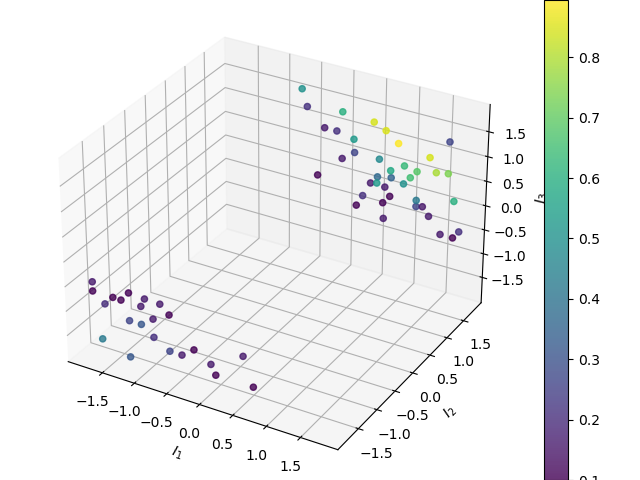

In [111]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)

clb = plt.colorbar(scat)

In [ ]:
# # Create a figure and a 3D Axes
# fig = plt.figure(1)
# ax = Axes3D(fig)
# plt.xlabel(r'$I_1$')
# plt.ylabel(r'$I_2$')
# ax.set_zlabel(r'$I_3$')

# # Create an init function and the animate functions.
# # Both are explained in the tutorial. Since we are changing
# # the the elevation and azimuth and no objects are really
# # changed on the plot we don't have to return anything from
# # the init and animate function. (return value is explained
# # in the tutorial.
# def init():
#     ax.scatter(amplitudes[:, 0][good_inds], 
#                amplitudes[:, 1][good_inds],
#                amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
    
#     return fig,

# def animate(i):
#     ax.view_init(elev=10., azim=i)
#     return fig,

# # Animate
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=360, interval=20, blit=True)
# # Save
# # anim.save('/Volumes/Lab/Users/praful/thresh_surface_comp_p.gif', writer='imagemagick', fps=30)
# plt.show()

In [112]:
all_elecs_array = np.unique(np.array(all_elecs))

In [113]:
all_elecs_array

array([470, 471, 480], dtype=uint16)

In [114]:
X_all = []
y_all = []

trials_all = []

In [115]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            triplet_trials[k] = prob_dict["num_trials"]

    good_inds = np.where(triplet_probs > p_thr)[0]
    
    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]
    X_pos = amplitudes[good_inds]*(amplitudes[good_inds] > 0)
    X_neg = amplitudes[good_inds]*(amplitudes[good_inds] < 0)
    trials = triplet_trials[good_inds]
    X_all_p = np.zeros((len(good_inds), 2 * len(all_elecs_array)))
    X_all_p[:, elec_inds] = X_pos
    X_all_p[:, elec_inds + len(all_elecs_array)] = -X_neg
    X_all.append(X_all_p)
    y_all.append(y)
    trials_all.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[good_inds])
    print(X_all_p)
    print(y)
    print(trials)

Pattern 90
[470 471 480]
[471 470 480]
[1 0 2]
[[-1.59375 -1.78125 -0.84375]
 [ 1.78125  0.46875  1.59375]
 [-0.65625 -1.40625 -1.78125]
 [-0.09375  1.40625  1.21875]
 [-0.09375 -1.59375 -1.59375]
 [ 0.84375  1.21875  1.03125]
 [-1.59375 -1.40625 -1.03125]
 [ 1.59375  1.78125  0.65625]
 [ 1.59375 -0.28125  1.78125]
 [ 0.28125  1.21875  0.84375]
 [-1.78125 -1.59375 -1.78125]
 [ 1.78125  0.09375  1.59375]
 [-1.78125 -1.78125 -0.46875]
 [-1.78125 -1.78125 -0.65625]
 [ 1.78125 -0.28125  1.59375]
 [-1.59375 -1.59375 -0.84375]
 [ 1.78125 -0.46875  1.59375]
 [ 0.28125 -1.40625 -1.40625]
 [ 0.84375 -0.46875  1.78125]
 [-1.21875 -1.21875 -1.40625]
 [ 0.28125  1.21875  1.78125]
 [ 0.46875  1.21875  1.03125]
 [ 1.40625  1.21875  0.28125]
 [ 0.09375 -1.78125 -1.59375]
 [ 1.40625 -0.09375  1.59375]
 [ 1.21875  1.03125  1.59375]
 [ 1.59375  0.09375  1.78125]
 [ 1.59375 -0.65625  1.78125]
 [ 1.78125  1.78125 -0.46875]
 [-0.84375 -1.78125 -1.21875]
 [ 1.03125  1.03125  1.78125]
 [ 1.78125  1.03125  1.

In [116]:
all_amps = np.vstack(X_all)
all_probs = np.hstack(y_all)
trials_all = np.hstack(trials_all)

In [117]:
all_amps

array([[-0.     , -0.     , -0.     ,  1.78125,  1.59375,  0.84375],
       [ 0.46875,  1.78125,  1.59375, -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     ,  1.40625,  0.65625,  1.78125],
       [ 1.40625, -0.     ,  1.21875, -0.     ,  0.09375, -0.     ],
       [-0.     , -0.     , -0.     ,  1.59375,  0.09375,  1.59375],
       [ 1.21875,  0.84375,  1.03125, -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     ,  1.40625,  1.59375,  1.03125],
       [ 1.78125,  1.59375,  0.65625, -0.     , -0.     , -0.     ],
       [-0.     ,  1.59375,  1.78125,  0.28125, -0.     , -0.     ],
       [ 1.21875,  0.28125,  0.84375, -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     ,  1.59375,  1.78125,  1.78125],
       [ 0.09375,  1.78125,  1.59375, -0.     , -0.     , -0.     ],
       [-0.     , -0.     , -0.     ,  1.78125,  1.78125,  0.46875],
       [-0.     , -0.     , -0.     ,  1.78125,  1.78125,  0.65625],
       [-0.     ,  1.78125,  1.593

In [118]:
all_amps.shape, all_probs.shape, trials_all.shape

((63, 6), (63,), (63,))

In [119]:
test_size = 0.2
train_amps, test_amps, train_probs, test_probs, train_trials, _ = train_test_split(all_amps, all_probs, trials_all, test_size=test_size)

In [125]:
degree = 2
interaction = True
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs, train_trials, train_amps, degree, interaction
)

In [126]:
multi_X.shape, multi_y.shape

((962, 28), (962,))

In [127]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [128]:
multi_weights

array([ -32.03554772,   21.49278346,   15.32843655,   15.07853883,
         20.1345406 ,    8.2513134 ,   11.15067122,   -3.2708009 ,
         -4.79786234,   -5.33129878,    0.        , -127.20098145,
         -7.87291942,   -2.56506172,   -2.53111983,   -7.96821198,
          0.        ,   -0.75077743,   -1.6829329 ,   -4.95703984,
        136.60351531,    0.        ,   -2.65511616,   -4.0031948 ,
         -4.13066243,   -0.20879153,   -0.43624374,   -0.99044016])

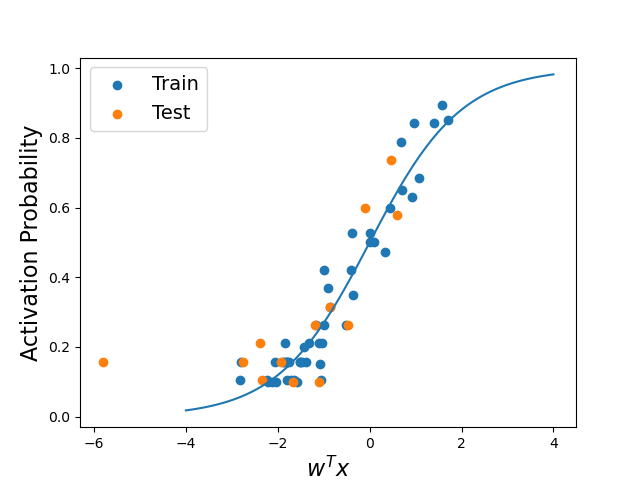

In [129]:
if interaction:
    poly = PolynomialFeatures(degree)
    test_X = poly.fit_transform(test_amps)
    train_X = poly.fit_transform(train_amps)

else:
    test_X = fitting.noInteractionPoly(test_amps, degree)
    train_X = fitting.noInteractionPoly(train_amps, degree)

test_y = test_probs
train_y = train_probs

plt.figure(2)
plt.figure(2).clear()
plt.scatter(train_X @ multi_weights, train_y, label='Train')
plt.scatter(test_X @ multi_weights, test_y, label='Test')
plt.xlabel(r'$w^Tx$', fontsize=16)
plt.ylabel('Activation Probability', fontsize=16)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.legend(fontsize=14)
plt.show()